In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorboard as tb
import datetime
from tensorflow.keras import layers

In [30]:
%reload_ext tensorboard

In [31]:
%tensorboard --logdir "logs/fit"

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-05-31 23:58:40.717775: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.

In [32]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [12]:
tf.__version__

'2.12.0'

In [13]:
pd.__version__

'1.5.3'

In [14]:
csv_file = 'credit_customers.csv'
dataframe = pd.read_csv(csv_file)

In [36]:
#experiment_id = "c1KCv3X3QvGwaXfgX1c432"
#experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
#df = experiment.get_scalars()
#df

In [15]:
dataframe['class'] = np.where(dataframe['class']=='bad', 0, 1)

In [16]:
dataframe[['sex', 'marriage']] = dataframe.personal_status.str.split(" ", expand = True)
dataframe.drop(['personal_status'], axis=1, inplace = True) # Personal status satırında cinsiyet ve medeni durum birlikte onları ayırıyoruz

In [17]:
input_features = dataframe.copy()
result_labels = input_features.pop('class')

In [18]:
inputs = {}

for name, column in input_features.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'checking_status': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'checking_status')>,
 'duration': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'duration')>,
 'credit_history': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'credit_history')>,
 'purpose': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'purpose')>,
 'credit_amount': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'credit_amount')>,
 'savings_status': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'savings_status')>,
 'employment': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'employment')>,
 'installment_commitment': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'installment_commitment')>,
 'other_parties': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'other_parties')>,
 'residence_since': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'residence_since')>,
 'property_mag

In [19]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = layers.Normalization()
norm.adapt(np.array(dataframe[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'normalization_1')>

In [21]:
preprocessed_inputs = [all_numeric_inputs]

In [22]:
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue

  lookup = layers.StringLookup(vocabulary=np.unique(input_features[name]))
  one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

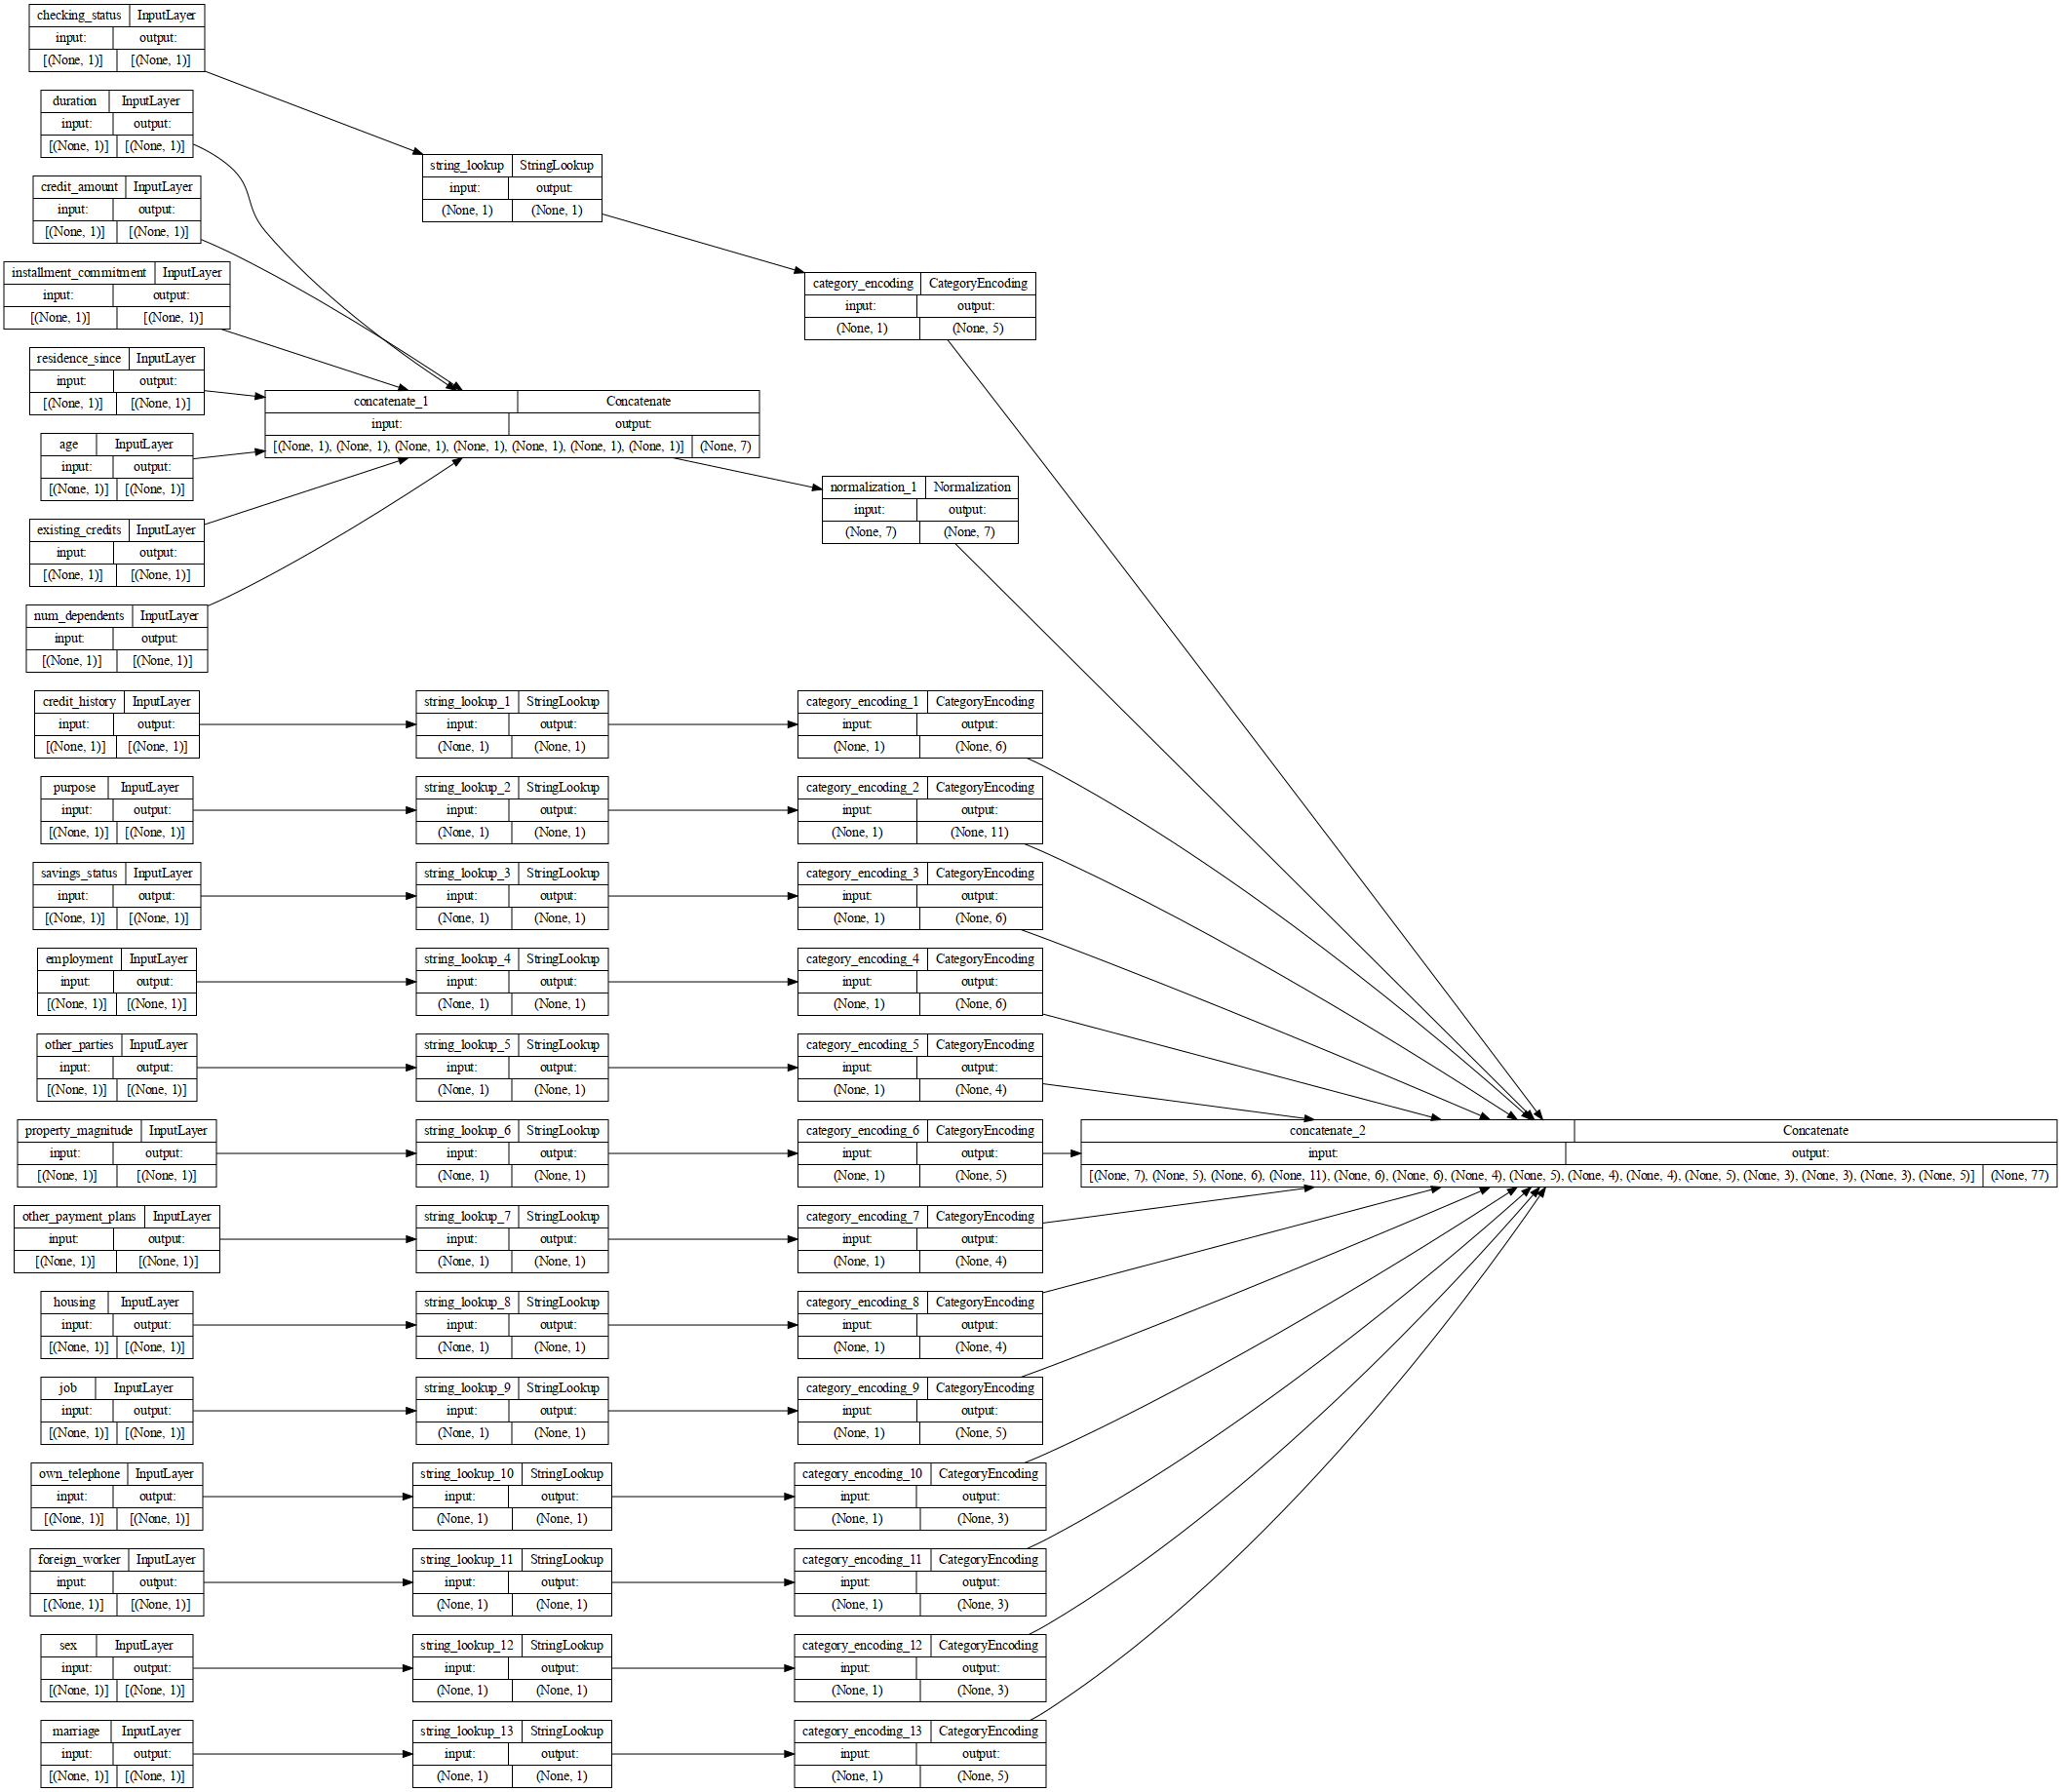

In [23]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

titanic_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

tf.keras.utils.plot_model(model = titanic_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

In [25]:
titanic_features_dict = {name: np.array(value) 
                         for name, value in input_features.items()}

In [26]:
features_dict = {name:values[:1] for name, values in titanic_features_dict.items()}
titanic_preprocessing(features_dict)

<tf.Tensor: shape=(1, 77), dtype=float32, numpy=
array([[-1.2364777 , -0.7451313 ,  0.91847706,  1.0469872 ,  2.7664564 ,
         1.027079  , -0.4282899 ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
  

In [27]:
def titanic_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(64),
    layers.Dense(1)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam())
  return model

titanic_model = titanic_model(titanic_preprocessing, inputs)

In [29]:
titanic_model.fit(x=titanic_features_dict, y=result_labels, epochs=10)


Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.6603
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.5315
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4922
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4745
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4673
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4641
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4635
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4599
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4567
Epoch 10/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4571
